# Minibackend example
This notebook aims to illustrate how `openeo-pg-parser-networkx` can be used together with `openeo-processes-dask` to execute an OpenEO process graph locally.
Note: This capability has also been called the "mini-backend" (see [GH issue with discussion](https://github.com/Open-EO/PSC/issues/16)).

We'll demonstrate this capability through the following steps:
- Load a process graph that represents a computation to be executed on an OpenEO backend and parse it to a traversible Python object using `openeo-pg-parser-networkx`
- Traverse the process graph and maps the nodes to a nested Python function
- Execute that function

Let's go!

## Process graph creation
We'll keep it super simple and use a process graph that: 
1) loads a small part of the boa_sentinel_2 collection
2) computes Enhanced Vegetation Index (EVI) for each pixel
3) multiplies each pixel with a scalar 
4) saves the result as a NetCDF

Specifically, the OpenEO processes necessary to encode this computation are:
1) `load_collection`
2) `reduce_dimension`
    - subprocess: `evi`-processgraph
3) `reduce_dimension`
    - subprocess: `min`
4) `save_result`

In [1]:
# First prepare the json with the required Git token stored in a .env file
import json
import os
from dotenv import load_dotenv

## Replace this string with location of local .env file containing GIT_TOKEN variable
dotEnv_location = "/home/tjellicoe/Documents/EOEPCA-and-OPENEO/openeo-dask-update/GIT/openeo-processes-cwl/.env"
load_dotenv(dotEnv_location)

GIT_TOKEN = os.getenv('GIT_TOKEN')

jsonFile = open("./data/cwl-example.json", "r") # Open the JSON file for reading
data = json.load(jsonFile) # Read the JSON into the buffer
jsonFile.close() # Close the JSON file
dict_update = {"git_token":GIT_TOKEN}
data["process_graph"]["cwl_preparation"]["arguments"].update(dict_update)

jsonFile = open("./data/cwl-example-token.json", "w+")
jsonFile.write(json.dumps(data,indent=2))
jsonFile.close()



In [2]:
from openeo_pg_parser_networkx import OpenEOProcessGraph

#EVI_GRAPH_PATH = "./data/pg-evi-example.json"
#EVI_GRAPH_PATH = "./data/cwl-example-stac.json"
#EVI_GRAPH_PATH = "./data/cwl-prepare-data.json"
EVI_GRAPH_PATH = "./data/cwl-example-token.json"

parsed_graph = OpenEOProcessGraph.from_file(EVI_GRAPH_PATH)

os.remove(EVI_GRAPH_PATH)

In [3]:
parsed_graph

We can see that `OpenEOProcessGraph` has parsed the process graph - let's plot it!


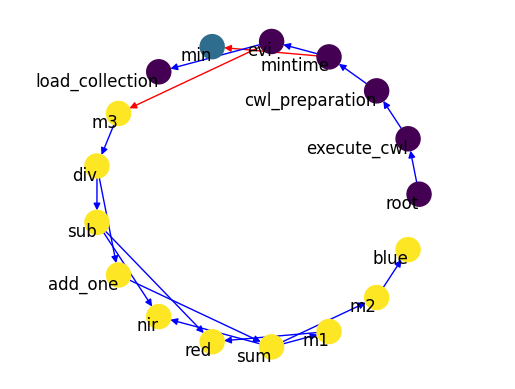

In [4]:
parsed_graph.plot()

The blue edges signify a `ResultReference` edge, where the result of the upstream process needs to be passed down to the downstream process as a parameter. 
E.g. in this process graph the results of `load_collection1` need to be passed on to `evi`. 
The red edges indicate `Callback` edges. These occur when a "parent" process calls upon a "child" process, i.e. to apply a reducer over specific dimension of a datacube. 
In this case the parent process is `reduce_dimension`, which applies the a sub-processgraph to calculate evi for all the pixels.  

## Execute the process graph

To execute a process graph, `OpenEOProcessGraph` needs to know which Python code to call for each of the nodes in the graph. This information is provided by a "process registry", which is basically a dictionary that maps `process_id` to their actual Python implementations as `Callable`s.

 When provided with a ProcessRegistry object (as defined in [openeo-processes-dask](https://github.com/Open-EO/openeo-processes-dask/blob/main/openeo_processes_dask/core.py)), `OpenEOProcessGraph` can translate the process graph into Python code using the `to_callable()` method.

In [5]:
#%pip install "openeo_processes_dask[implementations]"
%pip install "netCDF4"
#%pip install -r /home/tjellicoe/Documents/EOEPCA-and-OPENEO/openeo-dask-update/run-process-graphs/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [6]:
#%pip freeze

In [7]:
import os
import sys
orig_path = os.getcwd()
os.chdir("..")
path = os.getcwd()
os.chdir(orig_path)
#print(path)
#module_path = os.path.abspath(os.path.join('/home/tjellicoe/Documents/EOEPCA-and-OPENEO/openeo-dask-update/run-process-graphs'))
module_path = os.path.abspath(os.path.join(path))
if module_path not in sys.path:
    sys.path.append(module_path)
#print(sys.path)

In [8]:
import importlib
import inspect

from openeo_pg_parser_networkx import ProcessRegistry
from openeo_processes_dask_new.process_implementations.core import process
from openeo_pg_parser_networkx.process_registry import Process

process_registry = ProcessRegistry(wrap_funcs=[process])

# Import these pre-defined processes from openeo_processes_dask and register them into registry
processes_from_module = [
    func
    for _, func in inspect.getmembers(
        importlib.import_module("openeo_processes_dask_new.process_implementations"),
        inspect.isfunction,
    )
]

#print(processes_from_module)

specs_module = importlib.import_module("openeo_processes_dask_new.specs")
#print(specs_module)
#print((specs_module.filter_temporal))
specs = {}
for func in processes_from_module:
    #print("Working on " + str(func))
    try:
        specs.update({
            func.__name__: getattr(specs_module, func.__name__)
        })
    except:
        print(func.__name__ + " is missing")
        continue

for func in processes_from_module:
    process_registry[func.__name__] = Process(
        spec=specs[func.__name__], implementation=func
    )

# I/O processes aren't generic (yet), therefore have to custom define those. 
def load_collection(id, spatial_extent, temporal_extent, bands = [], properties = {}, **kwargs):
    # No generic implementation available, so need to implement locally!
    import xarray as xr
    ds = xr.open_dataset("./data/boa.nc").to_array(dim="bands")
    #print(ds)
    # outfile = ds.to_netcdf()
    # with open("input_file.nc", "wb") as file:
    #     file.write(outfile)
    # file.close()
    return ds

def save_result(data, format = 'netcdf', options = None):
    # No generic implementation available, so need to implement locally!
    import xarray as xr
    if isinstance(data, str):
        outfile = data
        with open("output_file.txt", "w") as file:
            file.write(outfile)
        file.close()
    elif isinstance(data, xr.DataArray):
        #print(data.attrs['reduced_dimensions_min_values'])
        print(data.coords.keys)
        try:
            data.attrs['reduced_dimensions_min_values'] = str(data.attrs['reduced_dimensions_min_values'])
        except:
            None
        try:
            data.attrs['spec'] = str(data.attrs['spec'])
        except:
            None
        try:
            data.attrs['processing:software'] = str(data.attrs['processing:software'])
        except:
            None
        outfile = data.to_netcdf()
        with open("output_file.nc", "wb") as file:
            file.write(outfile)    
        file.close()

from openeo_processes_dask_new.specs import load_collection as load_collection_spec
from openeo_processes_dask_new.specs import save_result as save_result_spec

process_registry["load_collection"] = Process(spec=load_collection_spec, implementation=load_collection)
process_registry["save_result"] = Process(spec=save_result_spec, implementation=save_result)

### Create callable for the process graph
pg_callable = parsed_graph.to_callable(process_registry=process_registry)

## Call the newly created callable 
pg_callable()


/home/tjellicoe/Documents/EOEPCA-and-OPENEO/openeo-dask-update/GIT/openeo-processes-cwl/openeo_processes_dask_new/process_implementations/math.py:89: RuntimeWarning: divide by zero encountered in divide
  result = x / y


<Response [201]>
Initial status is RUNNING please wait for processing to finish
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
Status is still running on ADES
<xarray.DataArray (y: 27, x: 40)>
array([[ -1.6242515 ,  -0.43810526,  -0.29859748, ...,  -0.24071082,
         -0.60606061,  -0.14350649],
       [  0.        , -15.4       ,  -3.3625    , ...,  -1.16101695,
         -0.21011236,  -0.5016129 ],
       [  0.        ,   0.        ,  -5.56372549, ...,  -0.95323741,
         -0.16856678,  -0.18700475],
       ...,
       [ -0.37015362,  -0.31596386,  -4.40625   , ...,  -0.67028986,
         -1.26470588,  -0.86198547],
       [ -1.33469945,  -1.0425    ,  -8.20689655, ...,  -0.70746269,
         -0.90402075,  -0.77114967],
       [ -0.18860947,  -